# Les imports :

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet

from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl
from iads import kmoyennes as km


# code 

In [71]:
import math

def moyenne(a):
    somme =0
    count =0
    for i in a:
        count+=1
        somme += i
    return (somme/count)

def ecart_Type(a):
    moy = moyenne(a)
    somme=0
    for i in a:
        somme+=(i - moy)**2
    return math.sqrt(somme/a.size)
def covariance(a,b):
    somme = 0;
    moy_a = moyenne(a)
    moy_b = moyenne(b)
    for i in range(len(a)):
        somme += (a[i] -  moy_a)*(b[i] - moy_b) 
    
    return (float(somme)/a.size )
def correlation(a , b): 
    return covariance(a,b)/(ecart_Type(a)*ecart_Type(b))

def normalisation(dataframe):
    mini, maxi = dataframe.min(), dataframe.max()
    normalized_df=(dataframe-mini)/(maxi -mini)
    return normalized_df

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o') # 'o' pour la classe +1
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x') # 'x' pour la classe -1

def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000])
    
# ------------------------ 

def createGaussianDataset(positive_center, positive_sigma, negative_center, negative_sigma, nb_points):
    """ 
        rend un LabeledSet 2D généré aléatoirement.
        Arguments:
        - positive_center (vecteur taille 2): centre de la gaussienne des points positifs
        - positive_sigma (matrice 2*2): variance de la gaussienne des points positifs
        - negative_center (vecteur taille 2): centre de la gaussienne des points négative
        - negative_sigma (matrice 2*2): variance de la gaussienne des points négative
        - nb_points (int):  nombre de points de chaque classe à générer
    """
    #TODO: A Compléter
    
    dataset =  ls.LabeledSet(nb_points) 
    positives = np.random.multivariate_normal(positive_center, positive_sigma, size=nb_points)
    negatives = np.random.multivariate_normal(negative_center, negative_sigma, size=nb_points)
    for i in range(nb_points):
        dataset.addExample(positives[i], 1)
        dataset.addExample(negatives[i], -1)
    return dataset
    
def split(labelset, percentageTrain):
    
    test = ls.LabeledSet(labelset.getInputDimension())
                      
    train = ls.LabeledSet(labelset.getInputDimension())
    a = []
    for i in range(labelset.size()):
        a.append((labelset.getX(i), labelset.getY(i)))
    np.random.shuffle(a)
    for i in range(int(percentageTrain * labelset.size())):
        train.addExample(a[i][0], a[i][1])
    for i in range(int(percentageTrain * labelset.size())+1, labelset.size()):
        test.addExample(a[i][0], a[i][1])
    return train, test

def affiche_base(LS):
    """ LabeledSet
        affiche le contenu de LS
    """
    for i in range(0,LS.size()):
        print("Exemple "+str(i))
        print("\tdescription : ",LS.getX(i))
        print("\tlabel : ",LS.getY(i))
    return


# Prétraitement

### Netoyage de ratings.csv 
Nous nous sommes debarassé de userId ainsi que de timestamp car ces deux colonnes ne sont pas significatives, nous avons fait la moyenne des notes de chaque film.

In [3]:
data_movies = pd.read_csv("data/movies.csv")



##### suppression des films sans genres

In [159]:
data_movies = data_movies[data_movies['genres'] != '(no genres listed)']

**reduction a 27278 films**

#### suppresion des film non presents dans ratings

In [26]:
data_ratings = pd.read_csv("data/ratings_clean.csv")


In [162]:
data_movies = data_movies[data_movies['movieId'].isin(data_ratings["movieId"])]

**reduction a 26502 films**

### suppresion des notations dont le film n'est pas present dans movies

In [164]:
data_ratings = data_ratings[data_ratings['movieId'].isin(data_movies["movieId"])]

**reduction à 26502**

### fusion des deux dataframes movies et ratings 

In [ ]:
data_movies = pd.merge(data_movies, data_ratings, on='movieId')

data_movies.set_index('movieId')

#### rajout des colonnes suivantes valeur 1 si le film appartient a cette categorie sinon 0

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western

In [167]:
categories = ["Action", "Adventure", "Animation", "Children" , "Comedy", "Crime","Documentary", "Drama", "Fantasy", "Film-Noir","Horror",  "Musical",  "Mystery", "Romance", "Sci-Fi", "Thriller", "War" , "Western"] 

In [168]:
for i in categories:
    data_movies[i] = 0

In [169]:
for index, row in data_movies.iterrows():
    s = row["genres"].split('|')
    for j in s:
        data_movies.loc[index, j] = 1

In [ ]:
data_movies = data_movies.drop("genres", axis=1)
data_movies = data_movies.drop("IMAX", axis=1)


In [ ]:
data_movies.set_index('movieId')

**sauvegarde dans un fichier csv le datframe netoyé pour ne pas avoir a tout exectuter a chaque fois** 

In [60]:
fichier = open("data/clean_MovieLens.csv", "w", encoding="utf-8")
fichier.write(data_movies.to_csv(index=False))

NameError: name 'data_movies' is not defined

In [2]:
data_movies_clean = pd.read_csv("data/clean_MovieLens.csv")

# Links

In [3]:
data_movies_clean.head(2)

,adult,movieId,original_title,popularity,release_month,release_year,vote_average,vote_count,rating,Action,...,te,am,jv,tg,ml,ms,lo,ay,ne,gl
0,0,862,Toy Story,22.773,10.0,1995.0,7.9,9550,3.921240,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8844,Jumanji,2.947,12.0,1995.0,7.1,5594,3.211977,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
liste_att = list(data_movies_clean.columns.values)

In [233]:
data_links = pd.read_csv("data/links.csv")

In [234]:
data_movies_clean= pd.merge(data_links, data_movies_clean, on='movieId')

In [237]:
data_movies_clean = data_movies_clean.drop("imdbId", axis=1)

In [239]:
data_movies_clean = data_movies_clean.drop("movieId", axis=1)

In [241]:
data_movies_clean.rename(columns={'tmdbId':'movieId'}, 
                 inplace=True)

In [247]:
data_movies_clean= pd.merge(movies, data_movies_clean, on='movieId')

In [74]:
data_movies_clean = data_movies_clean.drop("release_date", axis=1)

In [68]:
data_movies_clean = data_movies_clean.drop("genre_ids", axis=1)

In [69]:
adults = data_movies_clean["adult"].unique().tolist()


data_movies_clean.loc[data_movies_clean.adult ==  False, "adult"] = 0 
data_movies_clean.loc[data_movies_clean.adult != False , "adult"] = 1 

In [70]:
languages = data_movies_clean["original_language"].unique().tolist()


for i in languages:
    data_movies_clean[i] = 0

for i in languages:
    data_movies_clean.loc[data_movies_clean.original_language ==  i, i] = 1 
    data_movies_clean.loc[data_movies_clean.original_language != i, i]= 0

In [71]:
data_movies_clean = data_movies_clean.drop("original_language", axis=1)
data_movies_clean = data_movies_clean.drop("title_x", axis=1)


In [72]:
data_movies_clean = data_movies_clean.drop("title_y", axis=1)

In [26]:
data_movies_clean.dropna()

,adult,movieId,original_title,popularity,release_month,release_year,vote_average,vote_count,rating,Action,...,te,am,jv,tg,ml,ms,lo,ay,ne,gl
0,0,862,Toy Story,22.773,10.0,1995.0,7.9,9550,3.921240,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8844,Jumanji,2.947,12.0,1995.0,7.1,5594,3.211977,0,...,0,0,0,0,0,0,0,0,0,0
2,0,15602,Grumpier Old Men,6.076,12.0,1995.0,6.5,140,3.151040,0,...,0,0,0,0,0,0,0,0,0,0
3,0,31357,Waiting to Exhale,2.917,12.0,1995.0,6.1,55,2.861393,0,...,0,0,0,0,0,0,0,0,0,0
4,0,11862,Father of the Bride Part II,6.817,2.0,1995.0,6.1,288,3.064592,0,...,0,0,0,0,0,0,0,0,0,0
5,0,949,Heat,13.666,12.0,1995.0,7.8,3002,3.834930,1,...,0,0,0,0,0,0,0,0,0,0
6,0,11860,Sabrina,6.177,12.0,1995.0,6.1,260,3.366484,0,...,0,0,0,0,0,0,0,0,0,0
7,0,45325,Tom and Huck,3.567,12.0,1995.0,5.3,73,3.142049,0,...,0,0,0,0,0,0,0,0,0,0
8,0,9091,Sudden Death,5.890,10.0,1995.0,5.7,279,3.004924,1,...,0,0,0,0,0,0,0,0,0,0
9,0,710,GoldenEye,16.629,11.0,1995.0,6.8,1853,3.430029,1,...,0,0,0,0,0,0,0,0,0,0


In [75]:
fichier = open("data/clean_MovieLens.csv", "w", encoding="utf-8")
fichier.write(data_movies_clean.to_csv(index=False))

6871801

In [79]:
for i in liste_att:
    if i!="movieId" and pd.api.types.is_numeric_dtype(data_movies_clean[i]):
        data_movies_clean[i] = normalisation(data_movies_clean[i])

In [80]:
data_movies_clean

,adult,movieId,original_title,popularity,release_month,release_year,vote_average,vote_count,rating,Action,...,te,am,jv,tg,ml,ms,lo,ay,ne,gl
0,0.0,0.002044,Toy Story,0.421893,0.818182,0.827869,0.79,0.453466,0.760275,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.021015,Jumanji,0.044657,1.000000,0.827869,0.71,0.265622,0.602662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.037077,Grumpier Old Men,0.104194,1.000000,0.827869,0.65,0.006648,0.589120,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.074523,Waiting to Exhale,0.044086,1.000000,0.827869,0.61,0.002612,0.524754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.028188,Father of the Bride Part II,0.118293,0.090909,0.827869,0.61,0.013675,0.569909,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.002251,Heat,0.248611,1.000000,0.827869,0.78,0.142545,0.741096,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.028184,Sabrina,0.106115,1.000000,0.827869,0.61,0.012346,0.636996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.107722,Tom and Huck,0.056454,1.000000,0.827869,0.53,0.003466,0.587122,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.021602,Sudden Death,0.100655,0.818182,0.827869,0.57,0.013248,0.556650,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.001683,GoldenEye,0.304989,0.909091,0.827869,0.68,0.087987,0.651118,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




### fichiers PKL

<h1> Actors </h1>

In [14]:

acts = []
with open("data/act_v2.pkl",'rb') as f:
    acts = pickle.load(f)
    


In [15]:
x = []
with open("data/film_v2.pkl",'rb') as f:
    x = pickle.load(f)
for i in range(len(x)):
    for actor in acts[i]:
        actor["movieId"]= x[i]["id"]
        del actor["cast_id"]
        del actor["credit_id"]
        del actor["profile_path"]
        del actor["character"]
        

In [182]:
actors = pd.DataFrame([actor for d in acts for actor in d])
actors.set_index('id')

,gender,movieId,name,order
id,,,,
31,2,862,Tom Hanks,0
12898,2,862,Tim Allen,1
7167,2,862,Don Rickles,2
12899,2,862,Jim Varney,3
12900,2,862,Wallace Shawn,4
7907,2,862,John Ratzenberger,5
8873,1,862,Annie Potts,6
1116442,2,862,John Morris,7
12901,2,862,Erik von Detten,8


nouvelle colonne pour les acteurs moyenne des films ou ils ont joué

In [183]:

actors = pd.merge(actors, movies[["movieId", "vote_average", "vote_count"]], on='movieId')

In [184]:
actors[actors['name'] == 'Tom Hanks'].mean()

gender              2.000000
id                 31.000000
movieId         43735.122807
order               2.210526
vote_average        6.605263
vote_count       2141.771930
dtype: float64

In [185]:
df = actors[['id','vote_average']].groupby("id").mean()
df.rename(columns={'vote_average':'actor_avg'}, 
                 inplace=True)
actors = pd.merge(df, actors, on='id')

In [192]:
df = actors[['id','vote_count']].groupby("id").mean()
df.rename(columns={'vote_count':'actor_avg_count'}, 
                 inplace=True)
actors = pd.merge(df, actors, on='id')

In [195]:
fichier = open("data/clean_actors.csv", "w", encoding="utf-8")
fichier.write(actors.to_csv(index=False))

25519263

In [4]:
actors_clean = pd.read_csv("data/clean_actors.csv")

In [5]:
actors_clean.head(2)

,id,actor_avg_count,actor_avg,gender,movieId,name,order,vote_average,vote_count
0,1,875.0,6.455556,2,306,George Lucas,21,5.7,736
1,1,875.0,6.455556,2,87,George Lucas,66,7.2,4580


### films

In [243]:
delete = []
for i in range(len(x)):
    if "release_date" in x[i]:
        date = x[i]["release_date"].split('-')
        if len(date) == 3 : 
            x[i]["release_year"] = date[0]
            x[i]["release_month"] = date[1]
    else:
        delete.append(i)
for i in delete:
    del x[i]
        

In [244]:
movies = pd.DataFrame(x)

In [245]:
movies = movies.drop("backdrop_path", axis=1)
movies = movies.drop("overview", axis=1)
movies = movies.drop("poster_path", axis=1)
movies = movies.drop("video", axis=1)
movies.rename(columns={'id':'movieId'}, 
                 inplace=True)

In [246]:

movies.head(2)

,adult,genre_ids,movieId,original_language,original_title,popularity,release_date,release_month,release_year,title,vote_average,vote_count
0,False,"[16, 35, 10751]",862,en,Toy Story,22.773,1995-10-30,10,1995,Toy Story,7.9,9550
1,False,"[12, 14, 10751]",8844,en,Jumanji,2.947,1995-12-15,12,1995,Jumanji,7.1,5594


In [211]:
liste = set( x for j in movies["genre_ids"].tolist() for x in j)

In [213]:
len(liste)

19

In [220]:

for i in liste:
    movies[i] = 0


In [221]:
movies


,adult,genre_ids,movieId,original_language,original_title,popularity,release_date,release_month,release_year,title,...,16,80,18,9648,10770,53,27,28,10749,10751
0,False,"[16, 35, 10751]",862,en,Toy Story,22.773,1995-10-30,10,1995,Toy Story,...,0,0,0,0,0,0,0,0,0,0
1,False,"[12, 14, 10751]",8844,en,Jumanji,2.947,1995-12-15,12,1995,Jumanji,...,0,0,0,0,0,0,0,0,0,0
2,False,"[35, 10749]",15602,en,Grumpier Old Men,6.076,1995-12-22,12,1995,Grumpier Old Men,...,0,0,0,0,0,0,0,0,0,0
3,False,"[35, 18, 10749]",31357,en,Waiting to Exhale,2.917,1995-12-22,12,1995,Waiting to Exhale,...,0,0,0,0,0,0,0,0,0,0
4,False,[35],11862,en,Father of the Bride Part II,6.817,1995-02-10,02,1995,Father of the Bride Part II,...,0,0,0,0,0,0,0,0,0,0
5,False,"[28, 80, 18, 53]",949,en,Heat,13.666,1995-12-15,12,1995,Heat,...,0,0,0,0,0,0,0,0,0,0
6,False,"[35, 10749]",11860,en,Sabrina,6.177,1995-12-15,12,1995,Sabrina,...,0,0,0,0,0,0,0,0,0,0
7,False,"[28, 12, 18, 10751]",45325,en,Tom and Huck,3.567,1995-12-22,12,1995,Tom and Huck,...,0,0,0,0,0,0,0,0,0,0
8,False,"[28, 12, 18, 53]",9091,en,Sudden Death,5.890,1995-10-27,10,1995,Sudden Death,...,0,0,0,0,0,0,0,0,0,0
9,False,"[12, 28, 53]",710,en,GoldenEye,16.629,1995-11-16,11,1995,GoldenEye,...,0,0,0,0,0,0,0,0,0,0


### crew

In [18]:

c = []
with open("data/crew_v2.pkl",'rb') as f:
    c = pickle.load(f)


In [19]:
for i in range(len(x)):
    for crew in c[i]:
        crew["movieId"]= x[i]["id"]
        

In [20]:
crew = pd.DataFrame([crew_M for d in c for crew_M in d])

In [21]:
crew = crew.drop("credit_id", axis=1)
crew = crew.drop("profile_path", axis=1)
crew = crew.drop("job", axis=1)
#crew = crew.drop("id", axis=1)
crew = crew.dropna()

In [22]:
crew.head()

,department,gender,id,movieId,name
0,Directing,2,7879,862,John Lasseter
1,Writing,2,12891,862,Joss Whedon
2,Writing,2,7,862,Andrew Stanton
3,Writing,2,12892,862,Joel Cohen
4,Writing,0,12893,862,Alec Sokolow


In [23]:
departement = crew['department'].unique().tolist()

for i in departement:
    crew[i] = 0
'''   
for index, row in crew.iterrows():
    crew.loc[index, row["department"]] = 1
'''

'   \nfor index, row in crew.iterrows():\n    crew.loc[index, row["department"]] = 1\n'

In [24]:
for i in departement:
    crew.loc[crew.department == i , i] = 1 
    crew.loc[crew.department != i , i] = 0 


In [25]:
crew = crew.drop("department", axis=1)

In [26]:
crew = pd.merge(crew, data_movies_clean[["movieId", "vote_average", "vote_count"]], on='movieId')

In [27]:
df = crew[['id','vote_average']].groupby("id").mean()
df.rename(columns={'vote_average':'crew_avg'}, 
                 inplace=True)
crew = pd.merge(df, crew, on='id')

In [28]:
fichier = open("data/clean_crew.csv", "w", encoding="utf-8")
fichier.write(crew.to_csv(index=False))

31457282

In [6]:
crew = pd.read_csv("data/clean_crew.csv")

# Les problematiques : 

## clustering d'acteurs 

In [8]:
data_movies_clean.head(2)

,adult,movieId,original_title,popularity,release_month,release_year,vote_average,vote_count,rating,Action,...,te,am,jv,tg,ml,ms,lo,ay,ne,gl
0,0,862,Toy Story,22.773,10.0,1995.0,7.9,9550,3.921240,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8844,Jumanji,2.947,12.0,1995.0,7.1,5594,3.211977,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
actors_clean.loc[actors_clean["name"] == "Mark Hamill"]

,id,actor_avg_count,actor_avg,gender,movieId,name,order,vote_average,vote_count
18,2,1325.064516,6.493548,2,11,Mark Hamill,0,8.2,10843
19,2,1325.064516,6.493548,2,12122,Mark Hamill,5,5.9,298
20,2,1325.064516,6.493548,2,1891,Mark Hamill,0,8.3,9315
21,2,1325.064516,6.493548,2,1892,Mark Hamill,0,8.0,7676
22,2,1325.064516,6.493548,2,10350,Mark Hamill,15,4.3,107
23,2,1325.064516,6.493548,2,14919,Mark Hamill,1,7.5,385
24,2,1325.064516,6.493548,2,11428,Mark Hamill,16,5.3,172
25,2,1325.064516,6.493548,2,2294,Mark Hamill,16,6.3,728
26,2,1325.064516,6.493548,2,16121,Mark Hamill,1,6.9,122
27,2,1325.064516,6.493548,2,75596,Mark Hamill,2,6.1,7


In [10]:
crew.head()

,id,crew_avg,gender,movieId,name,Directing,Writing,Production,Editing,Art,Sound,Visual Effects,Crew,Lighting,Camera,Costume & Make-Up,Actors,vote_average,vote_count
0,1,6.867213,2,11,George Lucas,1,0,0,0,0,0,0,0,0,0,0,0,8.2,10843
1,1,6.867213,2,11,George Lucas,0,0,1,0,0,0,0,0,0,0,0,0,8.2,10843
2,1,6.867213,2,11,George Lucas,0,1,0,0,0,0,0,0,0,0,0,0,8.2,10843
3,1,6.867213,2,22588,George Lucas,0,1,0,0,0,0,0,0,0,0,0,0,6.1,19
4,1,6.867213,2,1891,George Lucas,0,1,0,0,0,0,0,0,0,0,0,0,8.3,9315


### etape 1 : quelles attributs sont significatifs :

In [11]:
## nouvelle table 

#avoir les types de films dans les quels ils jouent 

single_actors = pd.merge(actors_clean, data_movies_clean[["Action", "Adventure", "Animation", "Children" , "Comedy", "Crime","Documentary", "Drama", "Fantasy", "Film-Noir","Horror",  "Musical",  "Mystery", "Romance", "Sci-Fi", "Thriller", "War" , "Western", "movieId"]], on='movieId')


In [12]:
single_actors = single_actors.groupby(['id', 'name', 'gender']).mean()[["Action", "Adventure", "Animation", "Children" , "Comedy", "Crime","Documentary", "Drama", "Fantasy", "Film-Noir","Horror",  "Musical",  "Mystery", "Romance", "Sci-Fi", "Thriller", "War" , "Western", "order",	"vote_average"	,"vote_count"]]


In [13]:
single_actors = single_actors.reset_index()

In [60]:
dfCLustering = single_actors.drop("name", axis=1)

In [61]:
dfCLustering = dfCLustering.drop("id", axis=1)

In [62]:
dfCLustering = km.normalisation(dfCLustering)

In [63]:
#dfCLustering["gender_class"] = 0
dfCLustering.loc[dfCLustering.gender ==  1.0, "gender_class"] = 1
dfCLustering.loc[dfCLustering.gender == 0.5 , "gender_class"] = -1 

In [66]:
dfCLustering = dfCLustering.drop("gender", axis=1)
dfCLustering.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,order,vote_average,vote_count,gender_class
0,0.166667,0.166667,0.0,0.000000,0.166667,0.055556,0.777778,0.000000,0.111111,0.0,...,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.047338,0.645556,0.041548,1.0
1,0.400000,0.366667,0.3,0.100000,0.266667,0.133333,0.100000,0.100000,0.066667,0.0,...,0.033333,0.000000,0.433333,0.100000,0.033333,0.000000,0.020043,0.646667,0.064941,1.0
2,0.372549,0.235294,0.0,0.000000,0.274510,0.137255,0.058824,0.450980,0.019608,0.0,...,0.058824,0.137255,0.137255,0.274510,0.039216,0.058824,0.014438,0.639608,0.078372,1.0
3,0.162162,0.216216,0.0,0.000000,0.702703,0.108108,0.135135,0.297297,0.054054,0.0,...,0.081081,0.135135,0.108108,0.135135,0.000000,0.000000,0.028939,0.633514,0.055393,-1.0
4,0.076923,0.192308,0.0,0.019231,0.076923,0.096154,0.000000,0.173077,0.076923,0.0,...,0.192308,0.057692,0.250000,0.096154,0.019231,0.000000,0.008904,0.622885,0.012128,1.0


In [19]:
les_centresRand1, l_affectationv = km.kmoyennes(10, dfCLustering[:1000], 10, 100)

iteration 1  Inertie :  562.9429915147914 Difference: 79.83766837055254
iteration 2  Inertie :  483.10532314423887 Difference: 11.907095518763924


In [22]:
km.evaluation("Dunn",dfCLustering[:1000], les_centresRand1, l_affectationv )

6.345329042598425

## Classification

Predire le genre des acteurs depuis les informations sur leurs films

In [83]:
dfClassification = dfCLustering.drop("vote_count", axis=1)
dfClassification = dfClassification.drop("vote_average", axis=1)



In [117]:
dfClassification =dfClassification.dropna()

In [140]:
dfClassification = dfClassification.sample(10000)

In [141]:
une_base = ls.LabeledSet(2)
for index, row in dfClassification.iterrows():
    une_base.addExample(row[0:row.shape[0]-1] + [1],row["gender_class"])

In [142]:
a,b= [], []
train, test = split(une_base, 0.9)
def testPerceptron(labelset, taille, learningRate, train, test):
    #kernel = cl.KernelBias()
    for i in range(0,20):
        c = cl.ClassifierPerceptron(taille, learningRate)
        c.train(train)
        a.append(i)
        b.append(c.accuracy(test))
    plt.pyplot.plot(a, b, "r")
    plt.pyplot.show()
    

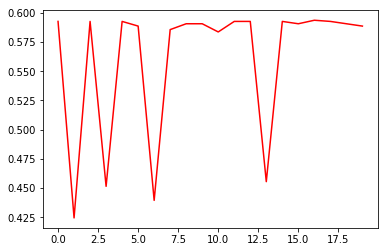

In [143]:
testPerceptron(une_base, 19, 0.03, train, test )

1
11
21


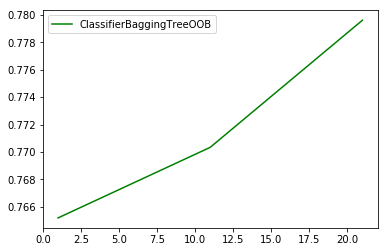

In [139]:
a,b, c,d= [], [], [], []

for i in range(1, 31, 10):
    print(i)
    #c1= cl.ClassifierRandomForest(i, 0.3, 0.01, True , 6)
    #c2 = cl.ClassifierBaggingTree(i,0.3,0.01,True)
    c3 =  cl.ClassifierBaggingTreeOOB(i,0.3, 0.01,True)
    #c1.train(train)
    #c2.train(train)
    c3.train(train)
    a.append(i)
    #b.append(c1.accuracy(test))
    
    #c.append(c2.accuracy(test))
    d.append(c3.accuracy(test))
#print(a,b ,"r", a,c, a, d, "g")
plt.pyplot.plot( a, d, "g" )
plt.pyplot.legend(["ClassifierBaggingTreeOOB"])

1
11
21


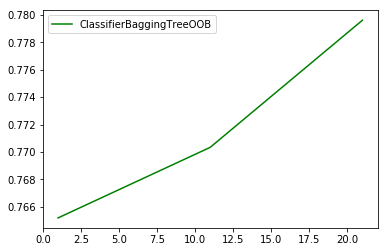

In [139]:
a,b, c,d= [], [], [], []

for i in range(1, 31, 10):
    print(i)
    #c1= cl.ClassifierRandomForest(i, 0.3, 0.01, True , 6)
    #c2 = cl.ClassifierBaggingTree(i,0.3,0.01,True)
    c3 =  cl.ClassifierBaggingTreeOOB(i,0.3, 0.01,True)
    #c1.train(train)
    #c2.train(train)
    c3.train(train)
    a.append(i)
    #b.append(c1.accuracy(test))
    
    #c.append(c2.accuracy(test))
    d.append(c3.accuracy(test))
#print(a,b ,"r", a,c, a, d, "g")
plt.pyplot.plot( a, d, "g" )
plt.pyplot.legend(["ClassifierBaggingTreeOOB"])

# Traitements :

# Resultats : 

# Conclusion : 